In [1]:
energy = 0.9
pressure= .004
radius = 6
tempSpike = 100

In [2]:
import numpy as np
import hoomd
import fresnel
import matplotlib.pyplot as plt
import scipy
import h5py
import gsd.hoomd
import itertools
import math
import time
import os
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [3]:
# This is not intended as a full tutorial on fresnel - see the
# fresnel user documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if ('version' not in dir(fresnel) or packaging.version.parse(
            fresnel.version.version) < FRESNEL_MIN_VERSION
            or packaging.version.parse(
                fresnel.version.version) >= FRESNEL_MAX_VERSION):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    L = snapshot.configuration.box
    
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(snapshot.particles.position),
                                       radius=0.5)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [252 / 255, 192 / 255, 203 / 255]),
                                                  roughness=0.5)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    box = fresnel.geometry.Box(scene, [L[0], L[1], L[2], 0, 0, 0], box_radius=.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(position=(L[0] * 2, L[1], L[2] * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L[2] * 1.4 + 1)
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [4]:
class SphereFilter(hoomd.filter.CustomFilter):
    def __init__(self, radius):
        self.radius = radius

    def __hash__(self):
        return hash((self.radius))

    def __eq__(self, other):
        return (isinstance(other, SphereFilter)
                and self.radius == other.radius)

    def __call__(self, state):
        with state.cpu_local_snapshot as snap:
            positions = snap.particles.position
            indices = (np.sum(positions*positions, axis=1) < (self.radius*self.radius))
            return np.copy(snap.particles.tag[indices])

In [5]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=1)
simulation.create_state_from_gsd(filename="../npt_targetpressure" + str(pressure) + "energy" + str(energy) + ".gsd")


In [6]:
integrator = hoomd.md.Integrator(dt=1e-3) # was 1e-3 changed because higher temp means atoms have important interactions fast
cell = hoomd.md.nlist.Cell(buffer=0.2)
lj = hoomd.md.pair.LJ(nlist=cell) 
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 5.0
integrator.forces.append(lj)

In [7]:
thisfilter = SphereFilter(radius) # change this num 3, 6

In [8]:
#nvt --> nve
nve = hoomd.md.methods.ConstantVolume(
    filter=hoomd.filter.All())
integrator.methods.clear()  # Remove all existing methods
integrator.methods.append(nve)
simulation.operations.integrator = integrator

In [9]:
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All())
thermodynamic_propertiesII = hoomd.md.compute.ThermodynamicQuantities(
    filter=thisfilter)

In [10]:
simulation.operations.computes.append(thermodynamic_properties)
simulation.operations.computes.append(thermodynamic_propertiesII)

In [11]:
simulation.always_compute_pressure = False
simulation.run(1)

In [12]:
scale_factor = 5.5

In [13]:
initial_temperature = thermodynamic_properties.kinetic_temperature

In [14]:
simulation.state.thermalize_particle_momenta(filter=thisfilter, kT=tempSpike) #change temp of filter particle 100, 14

In [15]:
logger = hoomd.logging.Logger(categories=['scalar', 'sequence'])
logger.add(thermodynamic_properties)
logger.add(thermodynamic_propertiesII)
logger.add(simulation, quantities=['timestep', 'walltime'])

if os.path.exists("heatSpike"+str(tempSpike)+"energy"+str(energy)+"r"+str(radius)+".h5"):
    os.remove("heatSpike"+str(tempSpike)+"energy"+str(energy)+"r"+str(radius)+".h5") # clear file if already created
    
hdf5_writer = hoomd.write.HDF5Log(trigger=hoomd.trigger.Periodic(10),
                                  filename="heatSpike"+str(tempSpike)+"energy"+str(energy)+"r"+str(radius)+".h5",
                                  mode='w',
                                  logger=logger)
simulation.operations.writers.append(hdf5_writer)

In [16]:
simulation.run(1000) # 10000

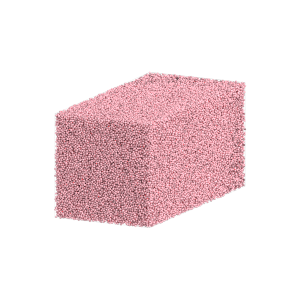

In [17]:
render(simulation.state.get_snapshot())

In [18]:
simulation.always_compute_pressure = True
simulation.run(1)
simulation.always_compute_pressure = False
thermodynamic_properties.pressure

0.8027482027330136

In [19]:
thermodynamic_propertiesII.pressure

0.031582853888825355

In [20]:
simulation.operations.writers.remove(hdf5_writer)
hdf5_file = h5py.File(name="heatSpike"+str(tempSpike)+"energy"+str(energy)+"r"+str(radius)+".h5", mode='r') # change name to normalized , case_one_spike etc.

In [21]:
#hdf5_file = h5py.File(name="heatSpike"+str(tempSpike)+"energy"+str(energy)+"r"+str(radius)+".h5", mode='r') # change name to normalized , case_one_spike etc.

In [22]:
#hdf5_file_spike = h5py.File(name='spike_case_four.h5', mode='r') # change name to normalized , case_one_spike etc.

In [23]:
def print_hdf5_structure(name, obj):
    print(name)

with h5py.File("heatSpike"+str(tempSpike)+"energy"+str(energy)+"r"+str(radius)+".h5", 'r') as hdf5_file_spike:
    hdf5_file.visititems(print_hdf5_structure)

hoomd-data
hoomd-data/Simulation
hoomd-data/Simulation/timestep
hoomd-data/Simulation/walltime
hoomd-data/md
hoomd-data/md/compute
hoomd-data/md/compute/ThermodynamicQuantities
hoomd-data/md/compute/ThermodynamicQuantities/degrees_of_freedom
hoomd-data/md/compute/ThermodynamicQuantities/kinetic_energy
hoomd-data/md/compute/ThermodynamicQuantities/kinetic_temperature
hoomd-data/md/compute/ThermodynamicQuantities/num_particles
hoomd-data/md/compute/ThermodynamicQuantities/potential_energy
hoomd-data/md/compute/ThermodynamicQuantities/pressure
hoomd-data/md/compute/ThermodynamicQuantities/pressure_tensor
hoomd-data/md/compute/ThermodynamicQuantities/rotational_degrees_of_freedom
hoomd-data/md/compute/ThermodynamicQuantities/rotational_kinetic_energy
hoomd-data/md/compute/ThermodynamicQuantities/translational_degrees_of_freedom
hoomd-data/md/compute/ThermodynamicQuantities/translational_kinetic_energy
hoomd-data/md/compute/ThermodynamicQuantities/volume
hoomd-data/md/compute/ThermodynamicQ

In [24]:
# # Accessing pressure data
# pressure_data = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities/pressure'][:])

# # Accessing pressure data for heated particles
# pressure_data_only_heated = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities_1/pressure'][:])

# # Accessing temperature data for heated particles
# temperature_data_only_heated = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities_1/kinetic_temperature'][:])


In [25]:
pressure_data = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities/pressure'][:])
temperature_data = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities/kinetic_temperature'][:])

In [26]:
# pressure_data_only_heated = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities_1/pressure'][:])
# temperature_data_only_heated = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities_1/kinetic_energy'][:])

In [27]:
# current_temperature_spike = thermodynamic_propertiesII.kinetic_temperature
# print(current_temperature_spike)

In [28]:
print("Temp Data:", temperature_data)

Temp Data: [1.22842953 1.18915321 1.17010804 1.17091713 1.17290127 1.17118744
 1.17803955 1.1787567  1.17940087 1.17361375 1.17545536 1.17516671
 1.17708992 1.17434875 1.17594374 1.17532734 1.17318641 1.1743425
 1.17502718 1.17493494 1.17498173 1.17458599 1.17395388 1.17452789
 1.17368924 1.17257772 1.17118712 1.17081339 1.17275915 1.17355424
 1.17468899 1.1758604  1.17621745 1.17449464 1.17358453 1.17471557
 1.17312045 1.1716092  1.16958815 1.17004342 1.17163492 1.17164491
 1.17057979 1.17083681 1.16972778 1.16722916 1.16724974 1.16859972
 1.16905377 1.16764739 1.16657599 1.16649906 1.16692593 1.1659549
 1.1654372  1.1658114  1.16637358 1.16747652 1.16759718 1.16701378
 1.16723272 1.16708072 1.16659819 1.1665659  1.16664131 1.16732209
 1.16772256 1.16747642 1.16729087 1.16607406 1.16431144 1.16406529
 1.16452554 1.16453398 1.16513865 1.16658621 1.16729506 1.16722099
 1.16703064 1.1671101  1.16667956 1.16644096 1.1665514  1.16605205
 1.16582099 1.16566681 1.16588582 1.16718708 1.168658

In [29]:
#pressure_data = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities/pressure'][:]) # pull data from log file

In [30]:
# current_pressure_spike = thermodynamic_propertiesII.pressure
# print(current_pressure_spike)

In [31]:
print("Pressure Data:", pressure_data)

Pressure Data: [0.25853596 0.42503466 0.51140981 0.51226604 0.50603007 0.51347352
 0.48631318 0.4841561  0.48391068 0.50955316 0.50484776 0.50847036
 0.50318359 0.51676848 0.51326593 0.51927642 0.53149215 0.53031214
 0.53058275 0.53373446 0.53639367 0.54118817 0.54735692 0.54837588
 0.55522    0.56340421 0.57225424 0.57609368 0.56973708 0.56784445
 0.56450727 0.56120495 0.56185784 0.57153315 0.57819194 0.57683076
 0.58685857 0.59694182 0.60894294 0.6102476  0.60640722 0.60908138
 0.61638641 0.6184975  0.62637955 0.63992617 0.64299916 0.64053888
 0.6421076  0.65177107 0.66017941 0.66417564 0.66580254 0.67281328
 0.67762075 0.67842937 0.67825459 0.67590387 0.6777487  0.68257577
 0.68418497 0.68748092 0.69237871 0.69559785 0.69842147 0.69887408
 0.70068378 0.7054178  0.71014202 0.71916477 0.73035861 0.7350945
 0.7365267  0.73935923 0.73928348 0.7354109  0.73451391 0.73706957
 0.74043616 0.74298383 0.74776139 0.75187115 0.75475097 0.76028345
 0.76472778 0.76855606 0.77034895 0.76730451 0.7

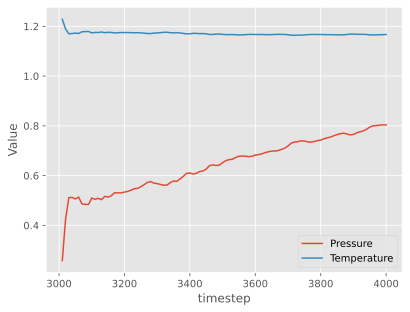

In [32]:
# pressure vs time
timesteps = np.float64(hdf5_file['hoomd-data/Simulation/timestep'][:])

plt.plot(timesteps, pressure_data, label='Pressure')
plt.plot(timesteps, temperature_data, label='Temperature')
plt.xlabel('timestep')
plt.ylabel('Value')
plt.legend()
plt.show()

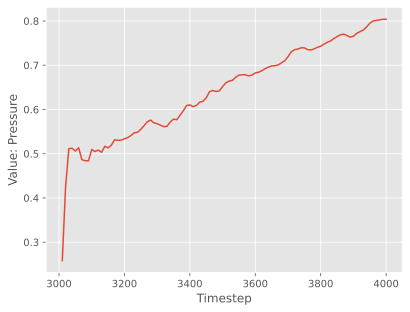

In [33]:
plt.plot(timesteps, pressure_data)
plt.xlabel('Timestep')
plt.ylabel('Value: Pressure')
plt.show()

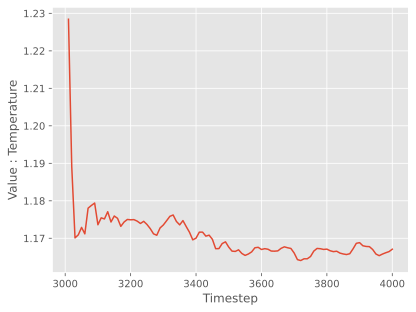

In [34]:
plt.plot(timesteps, temperature_data)
plt.xlabel('Timestep')
plt.ylabel('Value : Temperature')
plt.show()

In [35]:
if os.path.exists("heatSpike"+str(tempSpike)+"energy"+str(energy)+"r"+str(radius)+".gsd"):
    os.remove("heatSpike"+str(tempSpike)+"energy"+str(energy)+"r"+str(radius)+".gsd") # clear file if already created
hoomd.write.GSD.write(state=simulation.state, filename="heatSpike"+str(tempSpike)+"energy"+str(energy)+"r"+str(radius)+".gsd")